# Example Circuit
In this notebook, we demonstrate an example spatio-temporal circuit of the Antennal Lobe with the following configuration:

1. Pre-LN: Global Feedback Inhibition of OSN Axon-Terminal
2. Post-eLN: Local Feedforward Excitation of PN
3. Post-iLN: Local Feedforward Inhibition of PN

Note that the model described here is a rate-based model, where the Frequency-Current curve
of the Biophysical Spike Generators (e.g. PN Axon Hillock) are represented as 
Poisson Spike Generators. The rate of the Poisson Processes of each BSG is represented
by the Frequency-Current curve of a Noisy Connor-Stevens neuron. 
This was done for computational efficiency, which allows the massive experimentations 
across parameterizations and circuit configurations in our work.
However, note that the circuit can be easily changed to a spiking network by changing 
the model describing each BSG in the circuit.

See [[LAY20]](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007751#sec037) for more details on the Noisy Connor-Stevens neuron model.

In [1]:
import random
import pandas as pd
import numpy as np
import pycuda.autoprimaryctx
from neural.basemodel import Model
from neural.network import Network
from neural.network.operator import Operator, Repeat, Add
from pycuda.elementwise import ElementwiseKernel
import pycuda.gpuarray as garray
import matplotlib.pyplot as plt

import skcuda
import skcuda.misc
skcuda.misc.init()

/home/tingkai/anaconda3/envs/al-release/lib/python3.8/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


### Loading I/O

In [3]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]
pn = data['pn_input'][2]
dt = t[1] - t[0]

aff = df_aff.loc['acetone'].values # affinity rate of acetone
dr = 10. # dissociation rate fixed
N_r = len(aff) # N_r: number of receptors

### Model Definitions

In [4]:
class PostLNSyn(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0), x2=(0.0, 0.0, 1.0), x3=(1.0, 0.0, 1.0), I=0.0
    )
    Default_Params = dict(
        a1=1.0,
        b1=1.0,
        k=10.0,
        a2=1.0,
        b2=1.0,
        a3=1.0,
        b3=1.0,
        gmax=1.0,
    )

    def ode(self, u=0.0):
        self.d_x1 = self.a1 * self.x2 * (1.0 - self.x1) - self.b1 * self.x1- self.k * self.x1 * self.x3
        self.d_x2 = self.a2 * u * (1.0 - self.x2) - self.b2 * self.x2
        self.d_x3 = self.a3 * u * (1.0 - self.x3) - self.b3 * self.x3
        self.I = self.x1 * self.gmax


class PreLN(Operator):
    """BlockMean +  Repeat"""

    def __init__(self, operation="mean", block_size=1, **kwargs):
        assert operation in ["mean", "sum"]
        self.operation = operation
        self.block_size = block_size
        mean_output_size = int(kwargs["size"] // block_size)
        super().__init__(**kwargs)
        self.meaned = garray.empty(mean_output_size, dtype=self.dtype)

        self._repeat_kernel = ElementwiseKernel(
            "{0} *output, {0} *input".format(self.dtype),
            "output[i] = input[i / {}]".format(self.block_size),
            "Repeat",
        )

    def update(self, input):
        if np.isscalar(input):
            input = np.array([input])
        _input = input.reshape(-1, self.block_size)
        if self._backend == "cuda":
            if self.operation == "mean":
                skcuda.misc.mean(_input, out=self.meaned, axis=1)
            elif self.operation == "sum":
                skcuda.misc.sum(_input, out=self.meaned, axis=1)
            self._repeat_kernel(self.output, self.meaned)
        else:
            raise NotImplementedError


class dDNP(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0),
    )
    Default_Params = dict(
        a1=10.0,
        b1=1.0,
        k=10.0,
    )

    def ode(self, u=0.0, l=0.0):
        self.d_x1 = self.a1 * u * (1.0 - self.x1) - self.b1 * self.x1 - self.k * self.x1 * l


class PoissonCSN0(Model):
    Default_States = dict(
        spike_rate=(0.0, 0.0, 350.0), x=(0.0, 0.0, 1.0), r=0.0, spike=0.0, cx=0.0
    )
    Default_Params = dict(
        x7=7.06672200e-12,
        x6=-4.41125703e-09,
        x5=1.14814892e-06,
        x4=-1.61863859e-04,
        x3=1.34591675e-02,
        x2=-6.79691186e-01,
        x1=2.25636389e01,
        x0=-1.36299580e02,
    )

    def ode(self, I=0.0):
        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I
        self.d_x += Ip * self.x1
        Ip = Ip * I
        self.d_x += Ip * self.x2
        Ip = Ip * I
        self.d_x += Ip * self.x3
        Ip = Ip * I
        self.d_x += Ip * self.x4
        Ip = Ip * I
        self.d_x += Ip * self.x5
        Ip = Ip * I
        self.d_x += Ip * self.x6
        Ip = Ip * I
        self.d_x += Ip * self.x7
        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x


class PoissonCSN(Model):
    Default_States = dict(x=0.0, y=0.0, r=0.0, spike=0.0, cx=0.0)
    Default_Params = dict(
        x6=2.79621009e-09,
        x5=-9.55636291e-07,
        x4=1.25880567e-04,
        x3=-7.79496241e-03,
        x2=1.94672932e-01,
        x1=3.44246777,
        x0=5.11085315,
    )

    def ode(self, I=0.0):

        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I
        self.d_x += Ip * self.x1
        Ip = Ip * I
        self.d_x += Ip * self.x2
        Ip = Ip * I
        self.d_x += Ip * self.x3
        Ip = Ip * I
        self.d_x += Ip * self.x4
        Ip = Ip * I
        self.d_x += Ip * self.x5
        Ip = Ip * I
        self.d_x += Ip * self.x6
        self.y = self.d_x

        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x

class PoissonCSN1(Model):
    Default_States = dict(
        x=(0.0, 0., 1.), 
        r=0.0, 
        spike=0.0, 
        cx=0.0
    )            
    Default_Params = dict(
        x8=  2.62834699e-12,
        x7= -1.18820316e-09,
        x6=  2.24914051e-07,
        x5= -2.30971695e-05,
        x4=  1.38994273e-03,
        x3= -4.88554093e-02,
        x2=  8.87442880e-01,
        x1= -6.90178752e-01,
        x0=  8.95839969e-01,
    )

    def ode(self, I=0.0):
        self.x = 0.0
        Ip = 1.0
        self.d_x = Ip * self.x0
        Ip = Ip * I
        self.d_x += Ip * self.x1
        Ip = Ip * I
        self.d_x += Ip * self.x2
        Ip = Ip * I
        self.d_x += Ip * self.x3
        Ip = Ip * I
        self.d_x += Ip * self.x4
        Ip = Ip * I
        self.d_x += Ip * self.x5
        Ip = Ip * I
        self.d_x += Ip * self.x6
        Ip = Ip * I
        self.d_x += Ip * self.x7
        Ip = Ip * I
        self.d_x += Ip * self.x8
        self.r = random.uniform(0.0, 1.0)

    def post(self):
        self.spike = self.r < self.x
        self.cx += self.x

class OTP(Model):
    Default_States = dict(
        v=(0.0, 0, 1e9),
        I=0.0,
        uh=(0.0, 0.0, 1e9),
        duh=0.0,
        x1=(0.0, 0.0, 1.0),
        x2=(0.0, 0.0, 1.0),
        x3=(0.0, 0.0, 1000.0),
    )
    Default_Params = dict(
        br=1.0,
        dr=1.0,
        gamma=0.215,
        b1=0.8,
        a1=45.0,
        a2=146.1,
        b2=117.2,
        a3=2.539,
        b3=0.9096,
        kappa=8841,
        p=1.0,
        c=0.06546,
        Imax=85.0,
    )

    def ode(self, stimulus=0.0):
        self.d_x1 = self.br * self.v * (1.0 - self.x1) - self.dr * self.x1
        f = np.cbrt(self.x2 * self.x2) * np.cbrt(self.x3 * self.x3)
        self.d_x2 = self.a2 * self.x1 * (1.0 - self.x2) - self.b2 * self.x2 - self.kappa * f
        self.d_x3 = self.a3 * self.x2 - self.b3 * self.x3

        self.I = self.Imax * self.x2 / (self.x2 + self.c)

        self.d_uh = self.duh
        self.d_duh = -2 * self.a1 * self.b1 * self.duh + self.a1 * self.a1 * (stimulus - self.uh)
        self.v = self.uh + self.gamma * self.duh


class IonSyn(Model):
    Default_States = dict(
        x1=(0.0, 0.0, 1.0),
        I=0.0,
    )
    Default_Params = dict(
        a1=10.0,
        b1=1.0,
        gmax=10.0,
    )

    def ode(self, u=0.0):
        self.d_x1 = self.a1 * u * (1.0 - self.x1) - self.b1 * self.x1
        self.I = self.x1 * self.gmax

Specify circuit parameterization

In [5]:
params = {
    "osn_axt": {
        "a1": 101.6,
        "b1": 3.12,
        "k": 1e5
    },
    "osn-to-preln": {
        "a1": 1.06,
        "b1": 15.5,
        "gmax": 3232.6,
    },
    "osn-to-posteln": {
        'a1': 2.858053089117711,
        'b1': 1.4540529550164887,
        'k': 323039.26691518247,
        'a2': 1.5028414134309191,
        'b2': 98.82274646620965,
        'a3': 8.583048572622092,
        'b3': 5.9266873782378555,
        'gmax': 6.791877e+07
    },
    "osn-to-postiln": {
        'a1': 12.537946628371419,
        'b1': 3.5533912946105644,
        'k': 850654.7752613979,
        'a2': 64.39457099988905,
        'b2': 14.7847156711102,
        'a3': 4.946413745118113,
        'b3': 23.05951238421643,
        'gmax': 2.463306e+04
    },
    "osn_axt-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':1.273e5
    },
    "posteln-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':20.85
    },
    "postiln-to-pn": {
        'a1':1.,
        'b1':100.,
        'gmax':89.5
    }
}

Create Network

In [8]:
nn = Network(solver="euler")
inp = nn.input(num=1, name='stim')
inp_repeat = nn.add(Repeat, num=1, rep_size=N_r, name='stim-rep')
osn_otp = nn.add(OTP, num=N_r, br=dr*aff, dr=dr, name='OSN-OTP')
osn_bsg = nn.add(PoissonCSN, num=N_r, name='OSN-BSG')

osn_axt = nn.add(dDNP, num=N_r, **params["osn_axt"], name="OSN-Axt")
preln_syn = nn.add(IonSyn, num=N_r, **params["osn-to-preln"], name="OSN to PreLN")
preln_agg = nn.add(PreLN, num=N_r, operation='sum', block_size=N_r, name="Pre-LN Input")
preln = nn.add(PoissonCSN0, num=N_r, name="Pre-LN")
osn_axt_to_pn = nn.add(IonSyn, num=N_r, name="OSN-Axt to PN", **params['osn_axt-to-pn'])

posteln_syn = nn.add(PostLNSyn, num=N_r, name="OSN to Post-eLN", **params["osn-to-posteln"])
posteln = nn.add(PoissonCSN0, num=N_r, name="Post-eLN")
posteln_to_pn = nn.add(IonSyn, num=N_r, name="Post-eLN to PN", **params['posteln-to-pn'])

postiln_syn = nn.add(PostLNSyn, num=N_r, name="OSN to Post-iLN", **params["osn-to-postiln"])
postiln = nn.add(PoissonCSN0, num=N_r, name="Post-iLN")
postiln_to_pn = nn.add(IonSyn, num=N_r, name="Post-iLN to PN", **params['postiln-to-pn'])

pn_inp = nn.add(Add, num=N_r, name='PN-Dendrite')
pn_bsg = nn.add(PoissonCSN1, num=N_r, name='PN-BSG')

inp_repeat(input=inp)
osn_otp(stimulus=inp_repeat.output)
osn_bsg(I=osn_otp.I)
osn_axt(u=osn_bsg.x, l=preln.x)

preln_syn(u=osn_axt.x1)
preln_agg(input=preln_syn.I)
preln(I=preln_agg.output)
osn_axt_to_pn(u=osn_axt.x1)

posteln_syn(u=osn_bsg.x)
posteln(I=posteln_syn.I)
posteln_to_pn(u=posteln.x)

postiln_syn(u=osn_bsg.x)
postiln(I=postiln_syn.I)
postiln_to_pn(u=postiln.x)

pn_inp(u1=osn_axt_to_pn.I, u2=posteln_to_pn.I, u3=postiln_to_pn.I)
pn_bsg(I=pn_inp.output)

nn.compile(dtype=float, backend="cuda")

osn_bsg.record('x')
posteln.record('x')
postiln.record('x')
posteln_syn.record('x1')
postiln_syn.record('x1')

osn_axt.record('x1')
osn_axt_to_pn.record('I')
preln.record('x')
pn_bsg.record('x')
pn_inp.record('output')

/home/tingkai/anaconda3/envs/al-release/lib/python3.8/site-packages/neural/backend.py:384: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'OTP' for 'sm_70'
ptxas info    : Function properties for OTP
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 56 registers, 440 bytes cmem[0], 48 bytes cmem[2]

  mod = SourceModule(
/home/tingkai/anaconda3/envs/al-release/lib/python3.8/site-packages/neural/backend.py:384: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas info    : 64448 bytes gmem, 72 bytes cmem[3]
ptxas info    : Compiling entry function 'PoissonCSN' for 'sm_70'
ptxas info    : Function properties for PoissonCSN
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 32 registers, 424 bytes cmem[0], 48 bytes cmem[2]
ptxas info    : Compiling entry function 'generate_seed' for 'sm_70'
ptxas info    : Fu

Load input signal to the network instance

In [9]:
inp_g = garray.to_gpu(np.ascontiguousarray(stim))
inp(inp_g)

Run Network

In [10]:
nn.run(dt, verbose=True)

  0%|                                                                                          | 0/175000 [00:…

Plot Model I/O

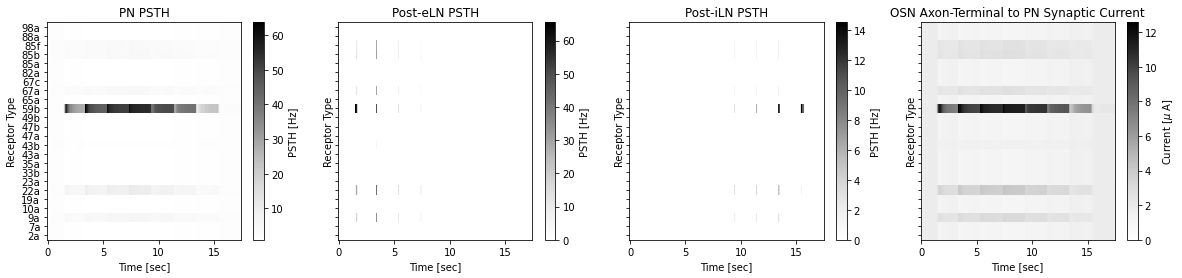

In [11]:
ds = 1000 # downsample for faster plotting
cmap = plt.cm.Greys
fig,axes = plt.subplots(1,4,figsize=(20,4), sharex=True, sharey=True)
cax = axes[0].pcolormesh(
    t[::ds],
    df_aff.columns,
    pn_bsg.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap
)
plt.colorbar(cax, ax=axes[0], label='PSTH [Hz]')
axes[0].set(title='PN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[1].pcolormesh(
    t[::ds],
    df_aff.columns,
    posteln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap
)
plt.colorbar(cax, ax=axes[1], label='PSTH [Hz]')
axes[1].set(title='Post-eLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[2].pcolormesh(
    t[::ds],
    df_aff.columns,
    postiln.recorder.x[:,::ds]/dt,
    shading='nearest',
    cmap=cmap
)
plt.colorbar(cax, ax=axes[2], label='PSTH [Hz]')
axes[2].set(title='Post-iLN PSTH', xlabel='Time [sec]', ylabel='Receptor Type')
cax = axes[3].pcolormesh(
    t[::ds],
    df_aff.columns,
    osn_axt_to_pn.recorder.I[:,::ds],
    shading='nearest',
    cmap=cmap
)
plt.colorbar(cax, ax=axes[3], label='Current [$\mu$ A]')
_ = axes[3].set(title='OSN Axon-Terminal to PN Synaptic Current', xlabel='Time [sec]', ylabel='Receptor Type')